In [13]:
pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: C:\Users\Beatriz\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [14]:
pip install torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: C:\Users\Beatriz\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [59]:
import warnings
warnings.filterwarnings('ignore')

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import time
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVC
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.nn import GCNConv, SAGEConv, GATConv

import networkx as nx
from scipy.sparse import csr_matrix
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report

### DataLoad

In [2]:
genes_df = pd.read_csv(r'METABRIC_RNA_Mutation_genes.csv')
genes_df.head(2)

,Patient_ID,BRCA1,BRCA2,PALB2,PTEN,TP53,ATM,CDH1,CHEK2,NBN,...,SRD5A1,SRD5A2,SRD5A3,ST7,STAR,TNK2,TULP4,UGT2B15,UGT2B17,UGT2B7
0,0,-1399.00,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,...,-1.1877,-0.0194,-1.6345,-0.2142,-0.5698,-1.1741,-1.4779,-0.5954,-0.8847,-0.3354
1,2,-1.38,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,...,-0.4412,0.4534,0.4068,0.7634,0.0231,0.9121,-0.9538,-0.2264,0.5398,-892.0000


In [3]:
genes_used = list(genes_df.drop(columns=['Patient_ID']).columns)
len(genes_used)

489

In [4]:
description_df = pd.read_csv(r'METABRIC_RNA_Mutation.csv').rename(columns={'patient_id':'Patient_ID'})
description_df.head(2)

C:\Users\Beatriz\AppData\Local\Temp\ipykernel_26396\3561426409.py:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  description_df = pd.read_csv(r'METABRIC_RNA_Mutation.csv').rename(columns={'patient_id':'Patient_ID'})


,Patient_ID,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [6]:
subtype_df = pd.read_csv(r'METABRIC_RNA_Mutation_subtype.csv').rename(columns={'patient_id': 'Patient_ID'})
subtype_df.head(2)

,Patient_ID,subtype
0,0,claudin-low
1,2,LumA


In [7]:
metabric_df = pd.merge(genes_df, subtype_df, on='Patient_ID', how='inner')
metabric_df.head(4)

,Patient_ID,BRCA1,BRCA2,PALB2,PTEN,TP53,ATM,CDH1,CHEK2,NBN,...,SRD5A2,SRD5A3,ST7,STAR,TNK2,TULP4,UGT2B15,UGT2B17,UGT2B7,subtype
0,0,-1399.0000,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,...,-0.0194,-1.6345,-0.2142,-0.5698,-1.1741,-1.4779,-0.5954,-0.8847,-0.3354,claudin-low
1,2,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,...,0.4534,0.4068,0.7634,0.0231,0.9121,-0.9538,-0.2264,0.5398,-892.0000,LumA
2,5,67.0000,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,...,0.0668,0.8344,1.7227,0.4024,-3.7172,-1.5538,1.3701,-0.1078,0.3655,LumB
3,6,0.6744,-0.5428,-1.6592,0.6369,1.6708,-888.0000,1.2491,-1.1889,-0.4174,...,-0.7078,0.8228,0.6819,-0.1948,-2.3286,-0.9924,-0.3154,0.2320,-0.4828,LumB


In [8]:
metabric_df.shape

(1904, 491)

In [9]:
drop_subtypes = ['NC', 'Normal', 'claudin-low']
print("Antes:", metabric_df['subtype'].value_counts().to_dict())
metabric_df = metabric_df[~metabric_df['subtype'].isin(drop_subtypes)].reset_index(drop=True)
print("Depois (contagens por subtipo):")
print(metabric_df['subtype'].value_counts())

Antes: {'LumA': 679, 'LumB': 461, 'Her2': 220, 'claudin-low': 199, 'Basal': 199, 'Normal': 140, 'NC': 6}
Depois (contagens por subtipo):
subtype
LumA     679
LumB     461
Her2     220
Basal    199
Name: count, dtype: int64


In [11]:
metabric_df['subtype_basal'] = metabric_df['subtype'].astype(str).str.contains('basal', case=False, na=False).astype(int)
metabric_df['subtype_basal'].head(2)

0    0
1    0
Name: subtype_basal, dtype: int32

* Transformação de categorias:

In [12]:
labels_raw = metabric_df['subtype'].astype(str).fillna('unknown')
label_map = {v: i for i, v in enumerate(sorted(labels_raw.unique()))}
metabric_df['subtype_label'] = labels_raw.map(label_map).astype(int)
print("Classes encontradas (label_map):", label_map)
metabric_df[['Patient_ID','subtype','subtype_label']]

Classes encontradas (label_map): {'Basal': 0, 'Her2': 1, 'LumA': 2, 'LumB': 3}


,Patient_ID,subtype,subtype_label
0,2,LumA,2
1,5,LumB,3
2,6,LumB,3
3,8,LumB,3
4,10,LumB,3
...,...,...,...
1554,7295,LumA,2
1555,7296,LumB,3
1556,7297,LumB,3
1557,7298,LumB,3


### Estrutura Inicial - Primeira Abordagem Construída

In [15]:
label_col = 'subtype_label' 
corr_method = 'pearson'
corr_threshold = 0.3 
node_feature_dim = 1

In [16]:
expr = metabric_df[genes_used].astype(float).fillna(0)
genes = list(expr.columns)
N_genes = len(genes)

* Aplicação da correlação:

In [17]:
corr = expr.corr(method=corr_method)
corr = corr.abs()
np.fill_diagonal(corr.values, 0)

* Construção da lista de arestas ponderadas por correlação (threshold):

In [18]:
edge_src = []
edge_dst = []
edge_attr = []
for i in range(N_genes):
    for j in range(i+1, N_genes):
        w = corr.iat[i, j]
        if abs(w) >= corr_threshold:
            edge_src += [i, j]
            edge_dst += [j, i]
            edge_attr += [w, w]

* O tensor que define os nós de origem e destino de todas as arestas
* edge_attr são atributos/“pesos” das arestas


In [19]:
edge_index = torch.tensor([edge_src, edge_dst], dtype=torch.long)
edge_attr = torch.tensor(edge_attr, dtype=torch.float).unsqueeze(1) if len(edge_attr)>0 else None

* mapear rótulos para inteiros:

In [21]:
labels_raw = metabric_df[label_col].astype(str).fillna('unknown')
label_map = {v:i for i,v in enumerate(sorted(labels_raw.unique()))}
y_all = labels_raw.map(label_map).values
n_classes = len(label_map)

* criar lista de objetos Data (um por paciente):

In [22]:
data_list = []
for idx in range(len(metabric_df)):
    sample_expr = expr.iloc[idx].values.astype(np.float32).reshape(N_genes, node_feature_dim)  # (N_genes,1)
    x = torch.tensor(sample_expr, dtype=torch.float)
    y = torch.tensor(y_all[idx], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)
    if edge_attr is not None:
        data.edge_attr = edge_attr
    data_list.append(data)

In [23]:
print("Max abs corr:", corr.abs().values.max())

Max abs corr: 0.5358964392824787


In [24]:
loader = DataLoader(data_list, batch_size=16, shuffle=True)

import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden=64, n_classes=2):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.lin = torch.nn.Linear(hidden, n_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # pooling por grafo
        return self.lin(x)
    
class CustomGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden=64, n_classes=2):
        super(CustomGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.lin = torch.nn.Linear(hidden, n_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)   # agrega nós por grafo -> (batch_size, hidden)
        return self.lin(x)               # logits por grafo (batch_size, n_classes)

C:\Users\Beatriz\AppData\Local\Temp\ipykernel_26396\2645491959.py:1: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  loader = DataLoader(data_list, batch_size=16, shuffle=True)


In [25]:
labels = [int(d.y.item()) for d in data_list]
train_list, test_list = train_test_split(data_list, test_size=0.2, random_state=42, stratify=labels)
train_list, val_list = train_test_split(train_list, test_size=0.25, random_state=42,
                                        stratify=[int(d.y.item()) for d in train_list])  # 60/20/20

train_loader = DataLoader(train_list, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_list,   batch_size=16, shuffle=False)
test_loader  = DataLoader(test_list,  batch_size=16, shuffle=False)

C:\Users\Beatriz\AppData\Local\Temp\ipykernel_26396\633256298.py:6: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_list, batch_size=16, shuffle=True)
C:\Users\Beatriz\AppData\Local\Temp\ipykernel_26396\633256298.py:7: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader   = DataLoader(val_list,   batch_size=16, shuffle=False)
C:\Users\Beatriz\AppData\Local\Temp\ipykernel_26396\633256298.py:8: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader  = DataLoader(test_list,  batch_size=16, shuffle=False)


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomGNN(in_channels=node_feature_dim, hidden=128, n_classes=n_classes).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = torch.nn.CrossEntropyLoss()

In [26]:
for epoch in range(1, 31):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        opt.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = crit(out, batch.y)
        loss.backward()
        opt.step()
        total_loss += loss.item() * batch.num_graphs

    model.eval()
    ys = []
    preds = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            pred = out.argmax(dim=1).cpu().numpy()
            y_true = batch.y.cpu().numpy()
            preds.append(pred)
            ys.append(y_true)
    y_pred = np.concatenate(preds)
    y_true = np.concatenate(ys)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Epoch {epoch} loss={total_loss/len(train_list):.4f} val_acc={acc:.4f} val_f1={f1:.4f}")

Epoch 1 loss=1.3974 val_acc=0.2885 val_f1=0.2570
Epoch 2 loss=1.3487 val_acc=0.3750 val_f1=0.3355
Epoch 3 loss=1.3418 val_acc=0.4391 val_f1=0.2893
Epoch 4 loss=1.3342 val_acc=0.4359 val_f1=0.2647
Epoch 5 loss=1.3092 val_acc=0.4359 val_f1=0.2647
Epoch 6 loss=1.2940 val_acc=0.4391 val_f1=0.2798
Epoch 7 loss=1.2773 val_acc=0.4359 val_f1=0.2647
Epoch 8 loss=1.2689 val_acc=0.4872 val_f1=0.3866
Epoch 9 loss=1.2630 val_acc=0.4359 val_f1=0.2647
Epoch 10 loss=1.2486 val_acc=0.4327 val_f1=0.2657
Epoch 11 loss=1.2386 val_acc=0.4359 val_f1=0.2652
Epoch 12 loss=1.2265 val_acc=0.4359 val_f1=0.2709
Epoch 13 loss=1.2460 val_acc=0.4327 val_f1=0.2669
Epoch 14 loss=1.2309 val_acc=0.4359 val_f1=0.2713
Epoch 15 loss=1.2338 val_acc=0.4327 val_f1=0.2669
Epoch 16 loss=1.2175 val_acc=0.4455 val_f1=0.2935
Epoch 17 loss=1.2133 val_acc=0.4327 val_f1=0.2651
Epoch 18 loss=1.2139 val_acc=0.4455 val_f1=0.2922
Epoch 19 loss=1.2213 val_acc=0.4423 val_f1=0.2866
Epoch 20 loss=1.2076 val_acc=0.4583 val_f1=0.3108
Epoch 21 

In [27]:
model.eval()
ys = []; preds = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        preds.append(out.argmax(dim=1).cpu().numpy())
        ys.append(batch.y.cpu().numpy())

y_pred = np.concatenate(preds)
y_true = np.concatenate(ys)
print("Test accuracy:", accuracy_score(y_true, y_pred))
print("Test F1 (weighted):", f1_score(y_true, y_pred, average='weighted'))

Test accuracy: 0.4423076923076923
Test F1 (weighted): 0.29138683946023397


In [28]:
print("N genes (nós):", N_genes)
print("edge_index shape:", edge_index.shape)            # (2, E)
print("n arestas (direcionadas):", edge_index.size(1))
print("edge_attr shape:", edge_attr.shape if edge_attr is not None else None)
print("exemplo primeiras 10 arestas (src,dst):")
print(edge_index.t()[:10])
print("x shape do 1º grafo (nós x features):", data_list[0].x.shape)
print("rótulo do 1º grafo:", data_list[0].y.item())

N genes (nós): 489
edge_index shape: torch.Size([2, 4])
n arestas (direcionadas): 4
edge_attr shape: torch.Size([4, 1])
exemplo primeiras 10 arestas (src,dst):
tensor([[149, 179],
        [179, 149],
        [238, 397],
        [397, 238]])
x shape do 1º grafo (nós x features): torch.Size([489, 1])
rótulo do 1º grafo: 2


* Embeddings de grafo (usar o modelo treinado para obter vetores por paciente e projetar com TSNE/UMAP)

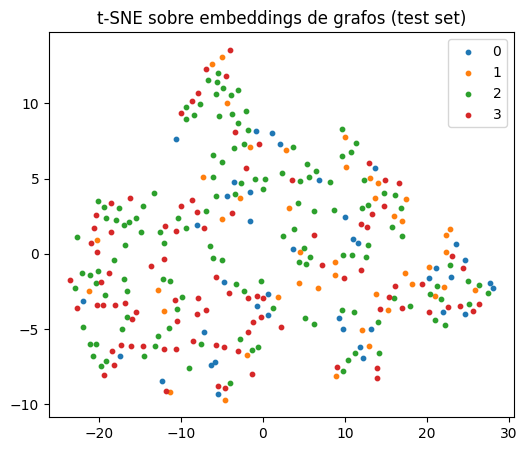

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

def compute_graph_embeddings(model, loader, device):
    model.eval()
    embs = []
    ys = []
    with torch.no_grad():
        for b in loader:
            b = b.to(device)
            # usar as conv internas do modelo para extrair embedding antes do linear final
            x = F.relu(model.conv1(b.x, b.edge_index))
            x = F.relu(model.conv2(x, b.edge_index))
            gemb = global_mean_pool(x, b.batch)   # (batch_size, hidden)
            embs.append(gemb.cpu().numpy())
            ys.append(b.y.cpu().numpy())
    return np.vstack(embs), np.concatenate(ys)

embs, labels = compute_graph_embeddings(model, test_loader, device)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
proj = tsne.fit_transform(embs)

plt.figure(figsize=(6,5))
for lab in np.unique(labels):
    mask = labels==lab
    plt.scatter(proj[mask,0], proj[mask,1], label=str(lab), s=10)
plt.legend()
plt.title("t-SNE sobre embeddings de grafos (test set)")
plt.show()

In [27]:
sample = data_list[0]

In [28]:
print(sample)

Data(x=[489, 1], edge_index=[2, 4], y=2, edge_attr=[4, 1])


In [29]:
print("x shape:", sample.x.shape)
print("edge_index:", sample.edge_index)

x shape: torch.Size([489, 1])
edge_index: tensor([[149, 179, 238, 397],
        [179, 149, 397, 238]])


In [33]:
# Diagnóstico
print("sample has attributes:", hasattr(sample, 'edge_index'))
if hasattr(sample, 'edge_index'):
    ei = sample.edge_index
else:
    ei = edge_index  # fallback (não recomendado)

# Se for tensor do PyTorch, convert para numpy para inspecionar facilmente
try:
    import torch
    if isinstance(ei, torch.Tensor):
        ei_np = ei.cpu().numpy()
    else:
        ei_np = np.array(ei)
except Exception:
    import numpy as np
    ei_np = np.array(ei)

print("edge_index shape:", ei_np.shape)
print("first 10 edges (transpose):", ei_np.T[:10])


sample has attributes: True
edge_index shape: (2, 4)
first 10 edges (transpose): [[149 179]
 [179 149]
 [238 397]
 [397 238]]


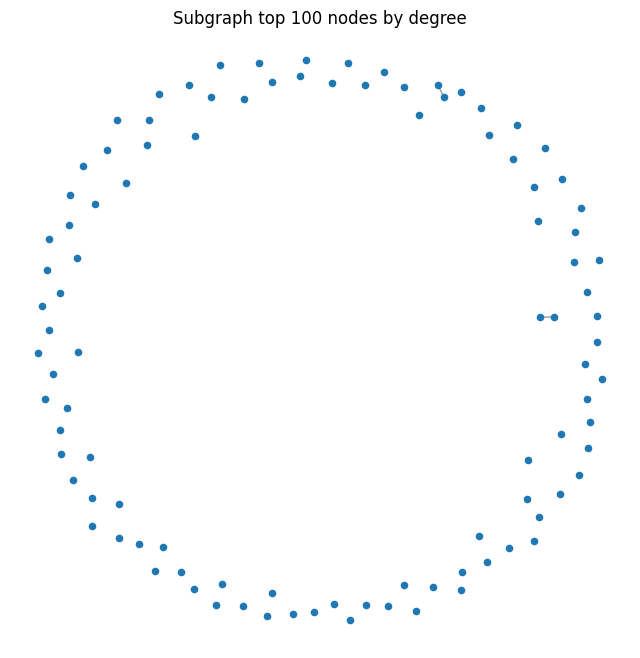

In [34]:
import networkx as nx
from torch_geometric.utils import to_networkx

sample = data_list[0]
G = to_networkx(Data(x=sample.x, edge_index=edge_index), to_undirected=True)
# escolher subgrafo dos top_k graus para visualizar
deg = dict(G.degree())
top_k = 100
top_nodes = sorted(deg, key=deg.get, reverse=True)[:top_k]
subG = G.subgraph(top_nodes).copy()

plt.figure(figsize=(8,8))
pos = nx.spring_layout(subG, seed=42, k=0.15)
nx.draw_networkx_nodes(subG, pos, node_size=20)
nx.draw_networkx_edges(subG, pos, alpha=0.4)
plt.title(f"Subgraph top {top_k} nodes by degree")
plt.axis('off')
plt.show()

### Código com ajustes - Segunda Abordagem Construída

* Funções para construir arestas:

In [ ]:
def build_edges_threshold(corr_df, threshold):
    """Cria arestas onde |corr| >= threshold. Retorna edge_index (2, E) e edge_attr (E,1)."""
    edge_src = []
    edge_dst = []
    edge_attr = []
    N = corr_df.shape[0]
    for i in range(N):
        for j in range(i+1, N):
            w = float(corr_df.iat[i, j])
            if abs(w) >= threshold:
                # adicionar bidirecional
                edge_src += [i, j]
                edge_dst += [j, i]
                edge_attr += [w, w]
    if len(edge_src) == 0:
        edge_index = torch.empty((2,0), dtype=torch.long)
        edge_attr_t = None
    else:
        edge_index = torch.tensor([edge_src, edge_dst], dtype=torch.long)
        edge_attr_t = torch.tensor(edge_attr, dtype=torch.float).unsqueeze(1)
    return edge_index, edge_attr_t

def build_edges_knn(corr_df, k):
    """Cada gene conecta aos k genes com maior |corr| (direcionado -> tornamos bidirecional depois)."""
    N = corr_df.shape[0]
    edge_src = []
    edge_dst = []
    edge_attr = []
    abs_corr = corr_df.abs()
    for i in range(N):
        # pega os índices dos k maiores exceto si mesmo
        topk = abs_corr.iloc[i].sort_values(ascending=False).head(k).index
        for col in topk:
            j = corr_df.columns.get_loc(col)
            if i == j:
                continue
            w = float(corr_df.iat[i, j])
            edge_src.append(i)
            edge_dst.append(j)
            edge_attr.append(w)

    edge_pairs = set()
    src2 = []
    dst2 = []
    attr2 = []
    for s,d,a in zip(edge_src, edge_dst, edge_attr):
        if (s,d) not in edge_pairs:
            edge_pairs.add((s,d))
            src2.append(s); dst2.append(d); attr2.append(a)
        if (d,s) not in edge_pairs:
            edge_pairs.add((d,s))
            src2.append(d); dst2.append(s); attr2.append(float(corr_df.iat[d,s]))
    if len(src2) == 0:
        return torch.empty((2,0), dtype=torch.long), None
    edge_index = torch.tensor([src2, dst2], dtype=torch.long)
    edge_attr = torch.tensor(attr2, dtype=torch.float).unsqueeze(1)
    return edge_index, edge_attr

def build_edges_mutual_knn(corr_df, k):
    """Conecta i-j somente se i está no top-k de j e j está no top-k de i."""
    N = corr_df.shape[0]
    abs_corr = corr_df.abs()
    topk_lists = {}
    for i in range(N):
        topk = list(abs_corr.iloc[i].sort_values(ascending=False).head(k).index)
        topk_idx = [corr_df.columns.get_loc(col) for col in topk if corr_df.columns.get_loc(col) != i]
        topk_lists[i] = set(topk_idx)

    src = []
    dst = []
    attr = []
    for i in range(N):
        for j in topk_lists[i]:
            if i in topk_lists[j]:  # mutual
                w = float(corr_df.iat[i, j])
                src += [i, j]
                dst += [j, i]
                attr += [w, w]
    if len(src) == 0:
        return torch.empty((2,0), dtype=torch.long), None
    edge_index = torch.tensor([src, dst], dtype=torch.long)
    edge_attr = torch.tensor(attr, dtype=torch.float).unsqueeze(1)
    return edge_index, edge_attr

def build_edges_auto_threshold(corr_df, percentile):
    """Define threshold como percentil das |correlação|s (exclui zeros diagonal)."""
    vals = np.abs(corr_df.values.flatten())
    vals = vals[vals > 0]  # excluir zeros que possivelmente foram colocados diagonal
    if vals.size == 0:
        thr = 0.0
    else:
        thr = np.percentile(vals, percentile)
    return build_edges_threshold(corr_df, thr)

In [31]:
label_col = 'subtype_label'   # ajuste se necessário
corr_method = 'pearson'
corr_threshold = 0.6          # usado na estratégia 'threshold' (pode ser ignorado se usar kNN)
k_neighbors = 8               # usado na estratégia 'knn' e 'mutual_knn'
auto_percentile = 90       
node_feature_dim = 1
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
# Preparo da matriz de expressão
expr = metabric_df[genes_used].astype(float).fillna(0)  # (N_samples, N_genes)
genes = list(expr.columns)
N_genes = len(genes)

# Matriz de correlação
corr = expr.corr(method=corr_method).astype(float)
np.fill_diagonal(corr.values, 0)

In [ ]:
# Escolha a estratégia aqui: 'threshold', 'knn', 'mutual_knn', 'auto_threshold'
strategy = 'auto_threshold'  

if strategy == 'threshold':
    edge_index, edge_attr = build_edges_threshold(corr, corr_threshold)
elif strategy == 'knn':
    edge_index, edge_attr = build_edges_knn(corr, k_neighbors)
elif strategy == 'mutual_knn':
    edge_index, edge_attr = build_edges_mutual_knn(corr, k_neighbors)
elif strategy == 'auto_threshold':
    edge_index, edge_attr = build_edges_auto_threshold(corr, auto_percentile)
else:
    raise ValueError("strategy inválida")

print("Edge index shape:", tuple(edge_index.shape))
if edge_attr is None:
    print("Edge attr: None")
else:
    print("Edge attr shape:", tuple(edge_attr.shape))

# Se não houver arestas, ao menos avise e use fallback kNN pequeno
if edge_index.numel() == 0:
    print("ATENÇÃO: nenhuma aresta foi construída com a estratégia escolhida. Usando fallback kNN=4.")
    edge_index, edge_attr = build_edges_knn(corr, k=4)
    print("Fallback edges shape:", tuple(edge_index.shape))

Edge index shape: (2, 23864)
Edge attr shape: (23864, 1)


In [ ]:
labels_raw = metabric_df[label_col].astype(str).fillna('unknown')
label_map = {v:i for i,v in enumerate(sorted(labels_raw.unique()))}
y_all = labels_raw.map(label_map).values
n_classes = len(label_map)

data_list = []
for idx in range(len(metabric_df)):
    sample_expr = expr.iloc[idx].values.astype(np.float32).reshape(N_genes, node_feature_dim)  # (N_genes,1)
    x = torch.tensor(sample_expr, dtype=torch.float)
    y = torch.tensor(y_all[idx], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)
    if edge_attr is not None:
        data.edge_attr = edge_attr
    data_list.append(data)

G: nodes = 489 edges = 11932


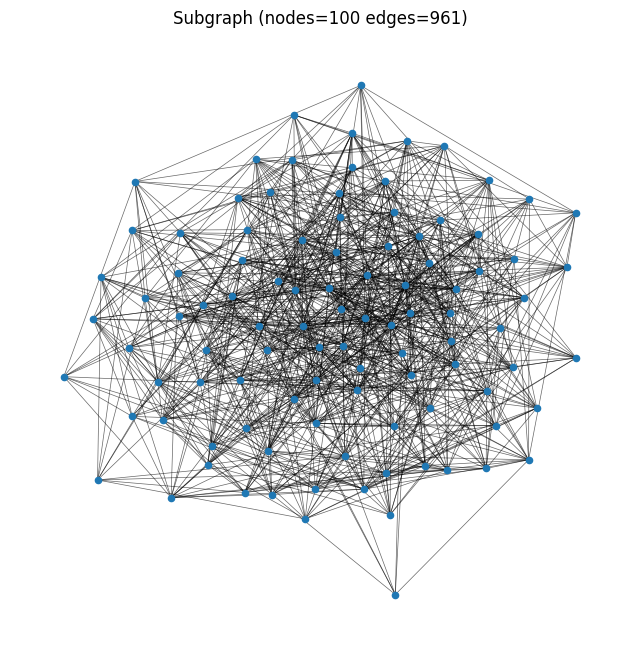

In [ ]:
from torch_geometric.utils import to_networkx

sample = data_list[0]
G = to_networkx(sample, to_undirected=True)
print("G: nodes =", G.number_of_nodes(), "edges =", G.number_of_edges())

top_k = 100
deg = dict(G.degree())
top_k = min(top_k, len(deg))
top_nodes = sorted(deg, key=deg.get, reverse=True)[:top_k]
subG = G.subgraph(top_nodes).copy()
if subG.number_of_edges() == 0:
    neighbors = set()
    for n in top_nodes:
        neighbors.update(G.neighbors(n))
    nodes_with_neighbors = set(top_nodes) | neighbors
    subG = G.subgraph(nodes_with_neighbors).copy()

plt.figure(figsize=(8,8))
pos = nx.spring_layout(subG, seed=seed, k=0.15)
nx.draw_networkx_nodes(subG, pos, node_size=20)
nx.draw_networkx_edges(subG, pos, edgelist=list(subG.edges()), alpha=0.6, width=0.5)
plt.title(f"Subgraph (nodes={subG.number_of_nodes()} edges={subG.number_of_edges()})")
plt.axis('off')
plt.show()

In [ ]:
labels = [int(d.y.item()) for d in data_list]
train_list, test_list = train_test_split(data_list, test_size=0.2, random_state=seed, stratify=labels)
train_list, val_list = train_test_split(train_list, test_size=0.25, random_state=seed,
                                        stratify=[int(d.y.item()) for d in train_list])  # 60/20/20

train_loader = DataLoader(train_list, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_list,   batch_size=16, shuffle=False)
test_loader  = DataLoader(test_list,  batch_size=16, shuffle=False)

C:\Users\Beatriz\AppData\Local\Temp\ipykernel_15444\28067738.py:9: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_list, batch_size=16, shuffle=True)
C:\Users\Beatriz\AppData\Local\Temp\ipykernel_15444\28067738.py:10: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader   = DataLoader(val_list,   batch_size=16, shuffle=False)
C:\Users\Beatriz\AppData\Local\Temp\ipykernel_15444\28067738.py:11: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader  = DataLoader(test_list,  batch_size=16, shuffle=False)


In [43]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden=64, n_classes=2):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.lin = torch.nn.Linear(hidden, n_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # pooling por grafo
        return self.lin(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=node_feature_dim, hidden=128, n_classes=n_classes).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
crit = torch.nn.CrossEntropyLoss()

In [ ]:
n_epochs = 30
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        opt.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = crit(out, batch.y)
        loss.backward()
        opt.step()
        total_loss += loss.item() * batch.num_graphs

    # validação
    model.eval()
    ys = []
    preds = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            pred = out.argmax(dim=1).cpu().numpy()
            y_true = batch.y.cpu().numpy()
            preds.append(pred)
            ys.append(y_true)
    if len(preds) > 0:
        y_pred = np.concatenate(preds)
        y_true = np.concatenate(ys)
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
    else:
        acc = f1 = 0.0

    print(f"Epoch {epoch:>2} loss={total_loss/len(train_list):.4f} val_acc={acc:.4f} val_f1={f1:.4f}")

In [ ]:
model.eval()
ys = []; preds = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        preds.append(out.argmax(dim=1).cpu().numpy())
        ys.append(batch.y.cpu().numpy())

if len(preds) > 0:
    y_pred = np.concatenate(preds)
    y_true = np.concatenate(ys)
    print("Test accuracy:", accuracy_score(y_true, y_pred))
    print("Test F1 (weighted):", f1_score(y_true, y_pred, average='weighted'))
else:
    print("Sem batches de teste (verifique os splits).")

Test accuracy: 0.4519230769230769
Test F1 (weighted): 0.3402438570165129


###  Otimização: Código Final - Última implementação (Resultados que foram adicionados no artigo)

* Preparação do dataset:

In [33]:
df = metabric_df
X = df[genes_used].astype(float).fillna(0).values
y = df["subtype_label"].astype(int).values  # 0,1,2,3

* treino/teste

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA para evitar overfitting (genes = alta dimensionalidade!)
# Mantém 95% da variância
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Dimensões após PCA:", X_train_pca.shape)

Dimensões após PCA: (1247, 392)


#### BASELINES (RESULTADOS ADICIONADOS NO ARTIGO)

In [ ]:
# Regressão Logística Multiclasse — solver sag mostra loss
log_reg = LogisticRegression(
    multi_class="multinomial",
    solver="saga",
    penalty="l2",
    C=0.5, # mais regularização -> menos overfitting
    max_iter=500,
    verbose=1
)

log_reg.fit(X_train_pca, y_train)

# Avaliação
log_pred = log_reg.predict(X_test_pca)
print("\n=== Classification Report — Logistic Regression ===")
print(classification_report(y_test, log_pred))

Dimensões após PCA: (1247, 392)
max_iter reached after 4 seconds

=== Classification Report — Logistic Regression ===
              precision    recall  f1-score   support

           0       0.51      0.50      0.51        40
           1       0.39      0.36      0.38        44
           2       0.63      0.65      0.64       136
           3       0.49      0.50      0.50        92

    accuracy                           0.54       312
   macro avg       0.51      0.50      0.51       312
weighted avg       0.54      0.54      0.54       312



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s finished


In [ ]:
# SVM — kernel RBF com regularização forte
svm_clf = SVC(
    C=1,              # controle de overfitting
    gamma="scale",
    kernel="rbf",
    probability=False
)

svm_clf.fit(X_train_pca, y_train)

# Avaliação
svm_pred = svm_clf.predict(X_test_pca)

print("\n=== Classification Report — SVM ===")
print(classification_report(y_test, svm_pred))



=== Classification Report — SVM ===
              precision    recall  f1-score   support

           0       0.58      0.38      0.45        40
           1       0.45      0.11      0.18        44
           2       0.58      0.85      0.69       136
           3       0.53      0.43      0.48        92

    accuracy                           0.56       312
   macro avg       0.54      0.44      0.45       312
weighted avg       0.55      0.56      0.53       312



Epoch 1/80 | Train Loss: 1.5074 | Val Loss: 1.4074
Epoch 2/80 | Train Loss: 1.4686 | Val Loss: 1.4066
Epoch 3/80 | Train Loss: 1.4444 | Val Loss: 1.4050
Epoch 4/80 | Train Loss: 1.3868 | Val Loss: 1.4021
Epoch 5/80 | Train Loss: 1.3683 | Val Loss: 1.3981
Epoch 6/80 | Train Loss: 1.3229 | Val Loss: 1.3927
Epoch 7/80 | Train Loss: 1.2988 | Val Loss: 1.3860
Epoch 8/80 | Train Loss: 1.2718 | Val Loss: 1.3778
Epoch 9/80 | Train Loss: 1.2381 | Val Loss: 1.3679
Epoch 10/80 | Train Loss: 1.2156 | Val Loss: 1.3569
Epoch 11/80 | Train Loss: 1.1949 | Val Loss: 1.3446
Epoch 12/80 | Train Loss: 1.1751 | Val Loss: 1.3309
Epoch 13/80 | Train Loss: 1.1477 | Val Loss: 1.3162
Epoch 14/80 | Train Loss: 1.1137 | Val Loss: 1.3006
Epoch 15/80 | Train Loss: 1.1184 | Val Loss: 1.2843
Epoch 16/80 | Train Loss: 1.0830 | Val Loss: 1.2671
Epoch 17/80 | Train Loss: 1.0574 | Val Loss: 1.2496
Epoch 18/80 | Train Loss: 1.0482 | Val Loss: 1.2313
Epoch 19/80 | Train Loss: 1.0268 | Val Loss: 1.2128
Epoch 20/80 | Train L

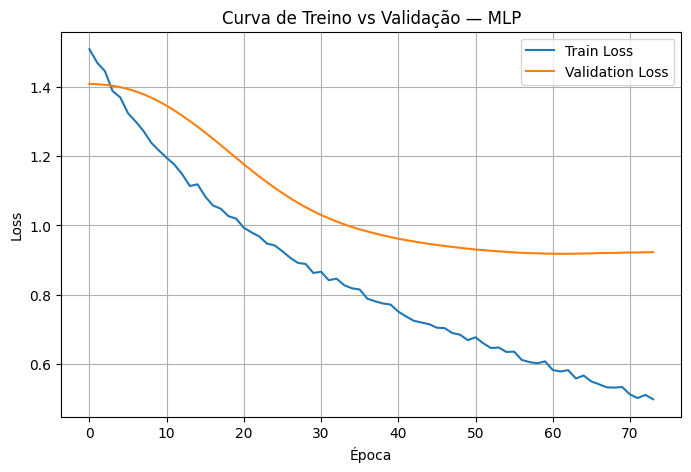

In [ ]:
# MLP MULTICLASSE COM PREVENÇÃO DE OVERFITTING (PyTorch)

# 1) Load dataset

df = metabric_df
X = df[genes_used].astype(float).fillna(0).values
y = df["subtype_label"].astype(int).values  # 0,1,2,3

# 2) Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3) Scaling + PCA (ESSENCIAL p/ evitar overfitting)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

pca = PCA(n_components=100)
X_train = pca.fit_transform(X_train)
X_test  = pca.transform(X_test)

# 4) Conversão para Tensor
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

# 5) Modelo MLP com Dropout + BatchNorm
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model = MLP(input_dim=X_train.shape[1], num_classes=4)

# 6) Loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 7) Training Loop com Early Stopping
epochs = 80
patience = 12
best_val_loss = np.inf
patience_counter = 0

train_losses = []
val_losses = []

for epoch in range(epochs):

    # TRAIN
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # VALIDATION
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_t)
        val_loss = criterion(val_outputs, y_test_t).item()
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss:.4f}")

    # EARLY STOPPING
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping ativado!")
        break

# Load best model
model.load_state_dict(best_model_state)

# 8) Avaliação final
model.eval()
with torch.no_grad():
    preds = model(X_test_t).argmax(dim=1).numpy()

print("\n===============================")
print("📌 Classification Report")
print("===============================")
print(classification_report(y_test, preds))
print("===============================")

# 9) Plot da curva de loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Curva de Treino vs Validação — MLP")
plt.legend()
plt.grid(True)
plt.show()

#### MODELOS GNN TAMBÉM TESTADOS - GCNNet, GraphSAGENet, GATNet (RESULTADOS NÃO ADICIONADOS NO ARTIGO)

In [ ]:
# Estratégias de construção de grafos
def build_knn_graph(X, k=10, mode='connectivity', metric='euclidean'):
    A = kneighbors_graph(X, n_neighbors=k, mode=mode, metric=metric, include_self=False)
    return A.tocsr()

def build_mutual_knn_graph(X, k=10, metric='euclidean'):
    A = build_knn_graph(X, k=k, metric=metric, mode='connectivity')
    A = (A > 0).astype(int)
    A_t = A.transpose().tocsr()
    mutual = A.multiply(A_t)
    return mutual

def build_threshold_graph(X, percentile=5):
    from sklearn.metrics import pairwise_distances
    D = pairwise_distances(X, metric='euclidean')
    thr = np.percentile(D[np.triu_indices_from(D, k=1)], percentile)
    A = (D <= thr).astype(int)
    np.fill_diagonal(A, 0)
    return csr_matrix(A)

def scipy_to_pyg_data(X, y, A_csr, device):
    G = nx.from_scipy_sparse_array(A_csr)
    data = from_networkx(G)
    data.x = torch.tensor(X, dtype=torch.float).to(device)
    data.y = torch.tensor(y, dtype=torch.long).to(device)
    return data

In [ ]:
# Models (slightly slimmer + dropout)
class GCNNet(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, num_classes=4, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)
        self.dropout = dropout
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class GraphSAGENet(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, num_classes=4, dropout=0.5, aggregator='mean'):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim, aggr=aggregator)
        self.conv2 = SAGEConv(hidden_dim, num_classes, aggr=aggregator)
        self.dropout = dropout
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class GATNet(nn.Module):
    def __init__(self, in_dim, hidden_dim=32, heads=4, num_classes=4, dropout=0.5):
        super().__init__()
        self.gat1 = GATConv(in_dim, hidden_dim, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_dim * heads, num_classes, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout
    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat2(x, edge_index)
        return x

Epoch 001 | train_loss 1.4544 | val_loss 1.4087 | val_acc 0.3462 | val_macroF1 0.2681
Epoch 010 | train_loss 1.1086 | val_loss 1.2701 | val_acc 0.4231 | val_macroF1 0.3910
Epoch 020 | train_loss 0.8555 | val_loss 1.1768 | val_acc 0.4679 | val_macroF1 0.4250
Epoch 030 | train_loss 0.6640 | val_loss 1.1337 | val_acc 0.5192 | val_macroF1 0.4753
Epoch 040 | train_loss 0.5167 | val_loss 1.1287 | val_acc 0.5385 | val_macroF1 0.4737
Epoch 050 | train_loss 0.4114 | val_loss 1.1426 | val_acc 0.5321 | val_macroF1 0.4593
Epoch 060 | train_loss 0.3866 | val_loss 1.1516 | val_acc 0.5385 | val_macroF1 0.4638
Epoch 070 | train_loss 0.3605 | val_loss 1.1558 | val_acc 0.5385 | val_macroF1 0.4638
Early stopping triggered at epoch 72 (no improvement in 30 epochs).
Training finished in 2.1s, best val_macroF1=0.4774
=== Test results ===
Test accuracy: 0.5609
Test macro-F1: 0.5241
Classification report:
              precision    recall  f1-score   support

           0       0.46      0.65      0.54       

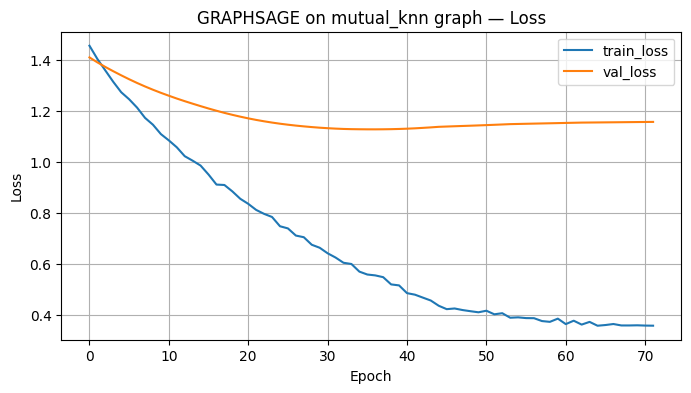

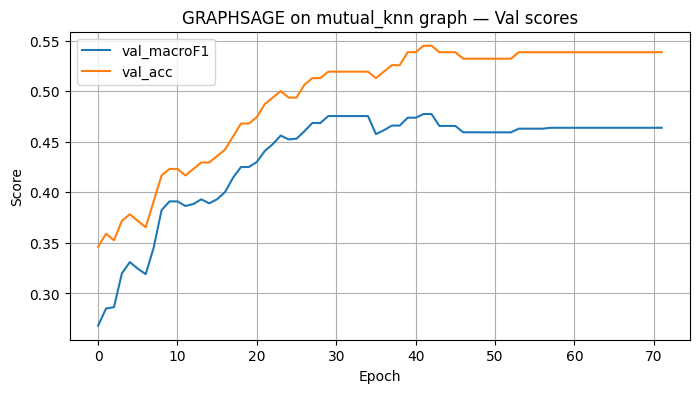

Epoch 001 | train_loss 2.0531 | val_loss 1.6221 | val_acc 0.1090 | val_macroF1 0.0766
Epoch 010 | train_loss 1.5040 | val_loss 1.4170 | val_acc 0.2949 | val_macroF1 0.2044
Epoch 020 | train_loss 1.4040 | val_loss 1.3800 | val_acc 0.1923 | val_macroF1 0.1491
Epoch 030 | train_loss 1.3878 | val_loss 1.3607 | val_acc 0.2115 | val_macroF1 0.2123
Epoch 040 | train_loss 1.3458 | val_loss 1.3552 | val_acc 0.2949 | val_macroF1 0.2821
Epoch 050 | train_loss 1.3516 | val_loss 1.3522 | val_acc 0.2949 | val_macroF1 0.2795
Epoch 060 | train_loss 1.3371 | val_loss 1.3525 | val_acc 0.2372 | val_macroF1 0.2374
Epoch 070 | train_loss 1.2946 | val_loss 1.3507 | val_acc 0.2756 | val_macroF1 0.2625
Epoch 080 | train_loss 1.3027 | val_loss 1.3495 | val_acc 0.3205 | val_macroF1 0.2968
Epoch 090 | train_loss 1.2966 | val_loss 1.3478 | val_acc 0.3333 | val_macroF1 0.3139
Epoch 100 | train_loss 1.2548 | val_loss 1.3457 | val_acc 0.2949 | val_macroF1 0.2777
Epoch 110 | train_loss 1.2846 | val_loss 1.3453 | val_

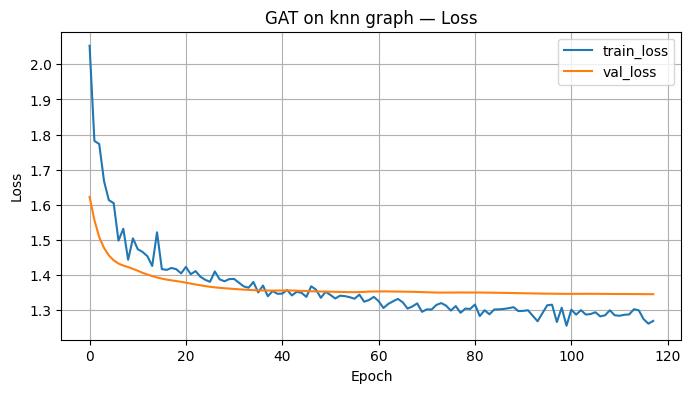

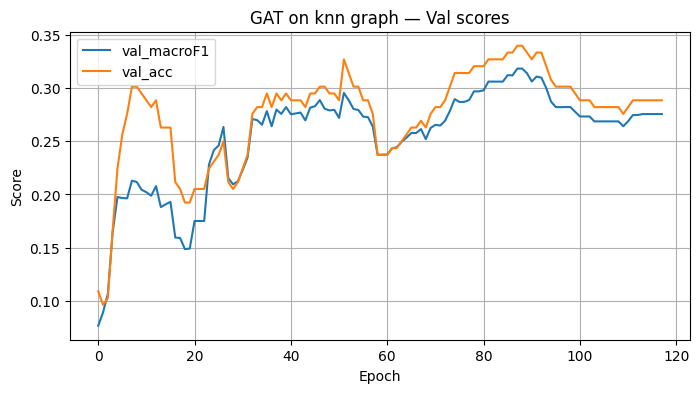

Epoch 001 | train_loss 1.3893 | val_loss 1.3957 | val_acc 0.2628 | val_macroF1 0.2060
Epoch 010 | train_loss 1.3427 | val_loss 1.3759 | val_acc 0.4295 | val_macroF1 0.3496
Epoch 020 | train_loss 1.2936 | val_loss 1.3616 | val_acc 0.4487 | val_macroF1 0.3880
Epoch 030 | train_loss 1.2500 | val_loss 1.3503 | val_acc 0.4295 | val_macroF1 0.3777
Epoch 040 | train_loss 1.2022 | val_loss 1.3427 | val_acc 0.3782 | val_macroF1 0.3507
Early stopping triggered at epoch 45 (no improvement in 30 epochs).
Training finished in 2.1s, best val_macroF1=0.4054
=== Test results ===
Test accuracy: 0.4071
Test macro-F1: 0.3846
Classification report:
              precision    recall  f1-score   support

           0       0.33      0.55      0.42        40
           1       0.27      0.30      0.28        44
           2       0.50      0.45      0.47       136
           3       0.41      0.34      0.37        92

    accuracy                           0.41       312
   macro avg       0.38      0.41    

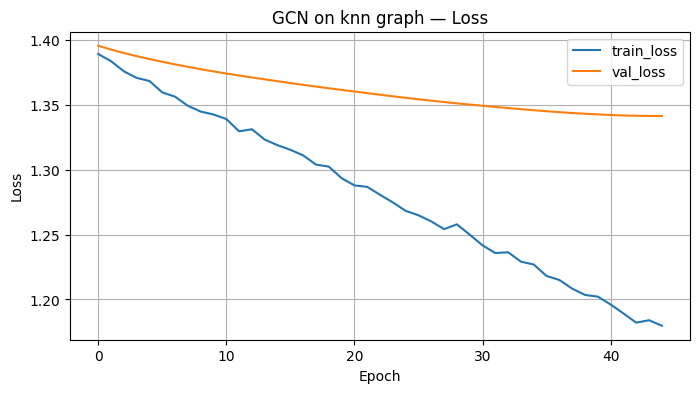

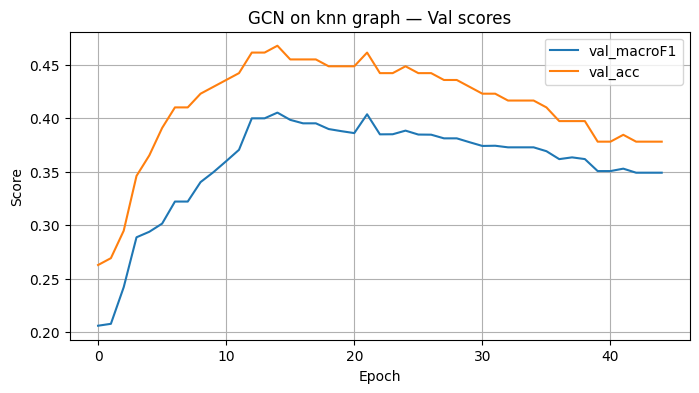

In [ ]:
# Training / eval helpers (improved)
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_epoch(model, data, optimizer, criterion, train_mask, max_grad_norm=None):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    if max_grad_norm is not None:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    optimizer.step()
    return loss.item()

@torch.no_grad()
def eval_model_logits(model, data, mask, criterion=None):
    model.eval()
    logits = model(data.x, data.edge_index)
    if criterion is not None:
        loss = criterion(logits[mask], data.y[mask]).item()
    else:
        loss = None
    preds = logits.argmax(dim=-1).cpu().numpy()
    labels = data.y.cpu().numpy()
    return preds[mask.cpu().numpy()], labels[mask.cpu().numpy()], loss

def run_pipeline(df,
                 genes_list,
                 graph_type='knn',
                 graph_param=10,
                 model_name='graphsage',
                 hidden_dim=64,
                 gat_heads=4,
                 test_size=0.2,
                 val_size=0.1,
                 random_state=42,
                 device='cuda',
                 epochs=200,
                 patience=30,
                 lr=1e-3,
                 weight_decay=5e-4,
                 dropout=0.5,
                 max_grad_norm=5.0,
                 seed=42,
                 plot=True):
    """
    df: pandas DataFrame with gene columns and 'subtype_label' numeric (0..3)
    genes_list: list of gene column names to use as features
    Returns: trained model, metrics dict, history (train_loss, val_loss)
    """
    seed_everything(seed)
    device = torch.device(device if torch.cuda.is_available() else 'cpu')

    y = df['subtype_label'].astype(int).to_numpy()
    X = df[genes_list].astype(float).fillna(0).to_numpy()

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)
    val_fraction_of_temp = val_size / (1.0 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_fraction_of_temp,
                                                      stratify=y_temp, random_state=random_state)

    X_all = np.vstack([X_train, X_val, X_test])
    y_all = np.concatenate([y_train, y_val, y_test])

    if graph_type == 'knn':
        A = build_knn_graph(X_all, k=int(graph_param))
    elif graph_type == 'mutual_knn':
        A = build_mutual_knn_graph(X_all, k=int(graph_param))
    elif graph_type == 'threshold':
        A = build_threshold_graph(X_all, percentile=float(graph_param))
    else:
        raise ValueError('unknown graph type')

    data = scipy_to_pyg_data(X_all, y_all, A, device)

    n_train = len(y_train)
    n_val = len(y_val)
    n_test = len(y_test)
    train_mask = torch.zeros(len(y_all), dtype=torch.bool, device=device)
    val_mask = torch.zeros(len(y_all), dtype=torch.bool, device=device)
    test_mask = torch.zeros(len(y_all), dtype=torch.bool, device=device)
    train_mask[:n_train] = True
    val_mask[n_train:n_train+n_val] = True
    test_mask[n_train+n_val:] = True
    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask

    in_dim = data.num_node_features
    num_classes = int(y_all.max()) + 1

    classes = np.unique(y_all)
    cw = compute_class_weight('balanced', classes=classes, y=y_all)
    class_weights = torch.tensor(cw, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    if model_name.lower() == 'gcn':
        model = GCNNet(in_dim, hidden_dim=hidden_dim, num_classes=num_classes, dropout=dropout).to(device)
    elif model_name.lower() == 'graphsage':
        model = GraphSAGENet(in_dim, hidden_dim=hidden_dim, num_classes=num_classes, dropout=dropout).to(device)
    elif model_name.lower() == 'gat':
        model = GATNet(in_dim, hidden_dim=max(8, hidden_dim//gat_heads), heads=gat_heads, num_classes=num_classes, dropout=dropout).to(device)
    else:
        raise ValueError("model_name must be 'gcn', 'graphsage' or 'gat'")

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8)

    best_val = -np.inf
    best_state = None
    bad = 0

    train_losses = []
    val_losses = []
    val_f1s = []
    val_accs = []

    start_time = time.time()
    for epoch in range(1, epochs+1):
        loss = train_epoch(model, data, optimizer, criterion, data.train_mask, max_grad_norm=max_grad_norm)
        train_losses.append(loss)

        val_preds, val_labels, val_loss = eval_model_logits(model, data, data.val_mask, criterion=criterion)
        val_losses.append(val_loss if val_loss is not None else np.nan)

        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='macro')
        val_accs.append(val_acc)
        val_f1s.append(val_f1)

        if val_loss is not None:
            scheduler.step(val_loss)

        if val_f1 > best_val + 1e-6:
            best_val = val_f1
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d} | train_loss {loss:.4f} | val_loss {val_loss:.4f} | val_acc {val_acc:.4f} | val_macroF1 {val_f1:.4f}")

        if bad >= patience:
            print(f"Early stopping triggered at epoch {epoch} (no improvement in {patience} epochs).")
            break

    total_time = time.time() - start_time
    print(f"Training finished in {total_time:.1f}s, best val_macroF1={best_val:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)

    test_preds, test_labels, test_loss = eval_model_logits(model, data, data.test_mask, criterion=criterion)
    test_acc = accuracy_score(test_labels, test_preds)
    test_macro_f1 = f1_score(test_labels, test_preds, average='macro')

    print("=== Test results ===")
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test macro-F1: {test_macro_f1:.4f}")
    print("Classification report:")
    print(classification_report(test_labels, test_preds))

    history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_f1s': val_f1s,
        'val_accs': val_accs
    }

   
    if plot:
        plt.figure(figsize=(8,4))
        plt.plot(train_losses, label='train_loss')
        plt.plot(val_losses, label='val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{model_name.upper()} on {graph_type} graph — Loss')
        plt.legend(); plt.grid(True); plt.show()

        plt.figure(figsize=(8,4))
        plt.plot(val_f1s, label='val_macroF1')
        plt.plot(val_accs, label='val_acc')
        plt.xlabel('Epoch'); plt.ylabel('Score')
        plt.title(f'{model_name.upper()} on {graph_type} graph — Val scores')
        plt.legend(); plt.grid(True); plt.show()

    metrics = {
        'test_acc': test_acc,
        'test_macro_f1': test_macro_f1,
        'test_preds': test_preds,
        'test_labels': test_labels
    }
    return model, metrics, history


model_sage, metrics_sage, history_sage = run_pipeline(
    df=metabric_df,
    genes_list=genes_used,
    graph_type='mutual_knn',
    graph_param=10,
    model_name='graphsage',
    hidden_dim=64,
    gat_heads=4,
    epochs=200,
    patience=30,
    device='cuda',
    seed=42,
    plot=True
)

model_gat, metrics_gat, history_gat = run_pipeline(
    df=metabric_df,
    genes_list=genes_used,
    graph_type='knn',
    graph_param=10,
    model_name='gat',
    hidden_dim=64,
    gat_heads=4,
    epochs=200,
    patience=30,
    device='cuda',
    seed=43,
    plot=True
)

model_gcn, metrics_gcn, history_gcn = run_pipeline(
    df=metabric_df,
    genes_list=genes_used,
    graph_type='knn',
    graph_param=10,
    model_name='gcn',
    hidden_dim=64,
    epochs=200,
    patience=30,
    device='cuda',
    seed=44,
    plot=True
)


#### MODELOS GNN FINAIS - GRAPHSAGE (GANHOU - RESULTADO ADICIONADA NO ARTIGO)

In [57]:
def fix_seeds(seed=42):
    import torch, random, numpy as np
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_seeds(42)

In [58]:
class GraphSAGE(nn.Module):
    def __init__(self,in_ch,hid,num_classes):
        super().__init__()
        self.conv1=SAGEConv(in_ch,hid)
        self.conv2=SAGEConv(hid,hid)
        self.drop = nn.Dropout(0.45)
        self.fc=nn.Linear(hid,num_classes)

    def forward(self,data):
        x,edge=data.x,data.edge_index
        x=F.relu(self.conv1(x,edge))
        x=self.drop(x)
        x=self.conv2(x,edge)
        x=self.drop(x)
        return self.fc(x)

In [ ]:
# BASE METABRIC
X = metabric_df[genes_used].astype(float).fillna(0).values
y = metabric_df["subtype_label"].astype(int).values 

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=45
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# PCA (reduz 20k genes -> 100 features)
pca = PCA(n_components=100)
X_train = pca.fit_transform(X_train)
X_test  = pca.transform(X_test)

# MATRIZ DE CORRELAÇÃO GENE–GENE
# mutual-KNN 
def g_mutual_knn(corr,k=12):
    idx=np.argsort(-corr,axis=1)[:,:k]
    edges=[]
    for i in range(len(idx)):
        for j in idx[i]:
            if i in idx[j]: edges.append((i,j))
    return torch.tensor(np.array(edges).T,dtype=torch.long)

edge_index = g_mutual_knn(corr,k=10)  
from torch_geometric.data import Data

features = torch.tensor(pca.transform(expr), dtype=torch.float32)
labels   = torch.tensor(y, dtype=torch.long)

data = Data(x=features, edge_index=edge_index.long(), y=labels)

train_mask = torch.zeros(len(labels), dtype=torch.bool)
train_mask[:len(y_train)] = True
test_mask = ~train_mask

def train_gnn(model,data,epochs=200,lr=1e-3,patience=10):
    opt=torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-3)

    best=np.inf; patience_ct=0
    train_hist=[]; val_hist=[]

    for e in range(epochs):

        # --- Train ---
        model.train()
        opt.zero_grad()
        out=model(data)
        loss=F.cross_entropy(out[train_mask],data.y[train_mask])
        loss.backward(); opt.step()

        model.eval()
        with torch.no_grad():
            val=F.cross_entropy(out[test_mask],data.y[test_mask]).item()

        train_hist.append(loss.item())
        val_hist.append(val)

        if val<best:
            best=val; patience_ct=0
            best_state=model.state_dict()
        else:
            patience_ct+=1
            
        if patience_ct>=patience:
            print("\n⚠ Early Stopping ativado — evitando overfitting\n")
            break

    model.load_state_dict(best_state)

    preds = model(data).argmax(dim=1).cpu().numpy()
    print(classification_report(data.y[test_mask].numpy(),preds[test_mask]))

    plt.figure(figsize=(8,5))
    plt.plot(train_hist, label="Train Loss")
    plt.plot(val_hist, label="Validation Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.title(f"Curva de Treino vs Validação — {model.__class__.__name__}")
    plt.legend()
    plt.grid(True)
    plt.show()


⚠ Early Stopping ativado — evitando overfitting

              precision    recall  f1-score   support

           0       0.82      0.46      0.59        50
           1       0.50      0.26      0.34        61
           2       0.51      0.84      0.64       103
           3       0.56      0.46      0.50        98

    accuracy                           0.55       312
   macro avg       0.60      0.51      0.52       312
weighted avg       0.57      0.55      0.53       312



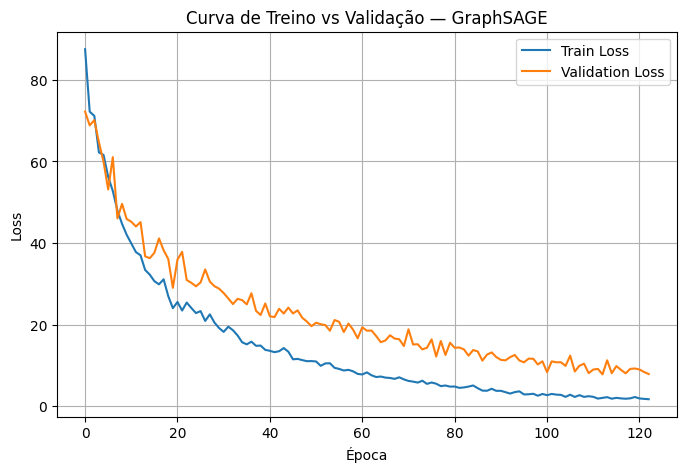

In [55]:
sage = GraphSAGE(in_ch=100,hid=128,num_classes=4)
train_gnn(sage, data)

##### Interpretação do grafo gerado

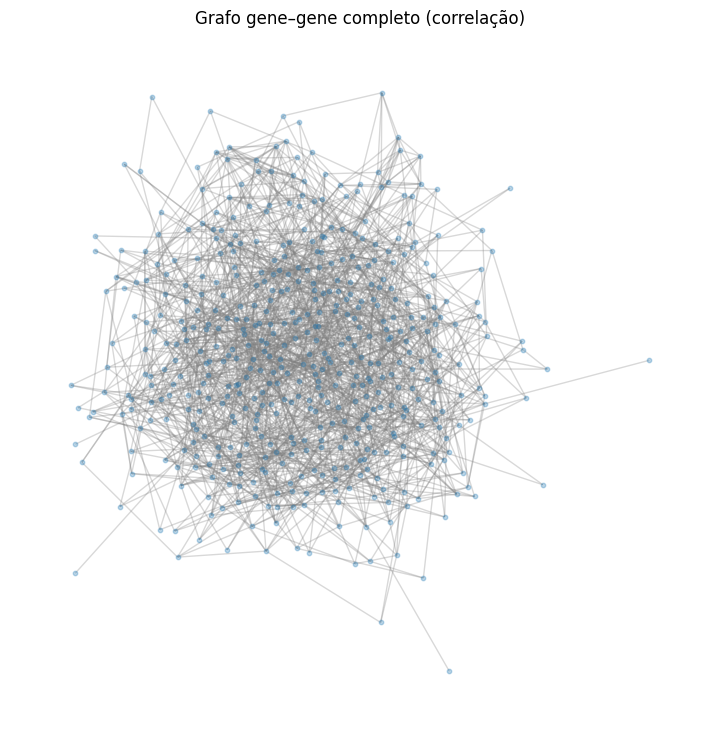

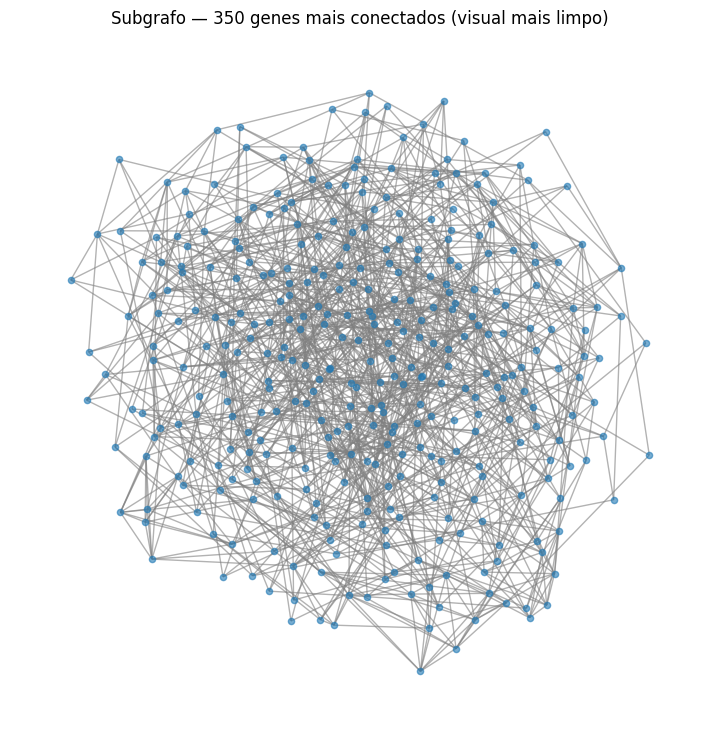

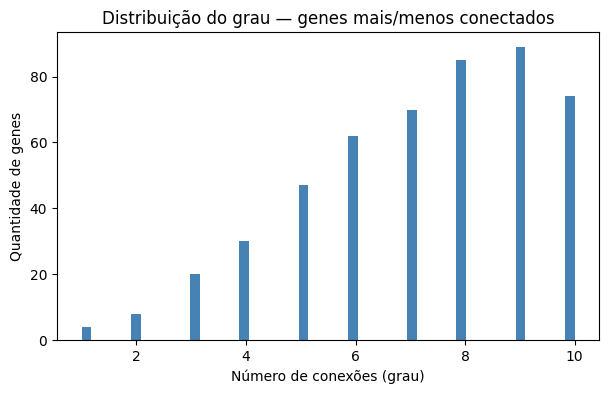

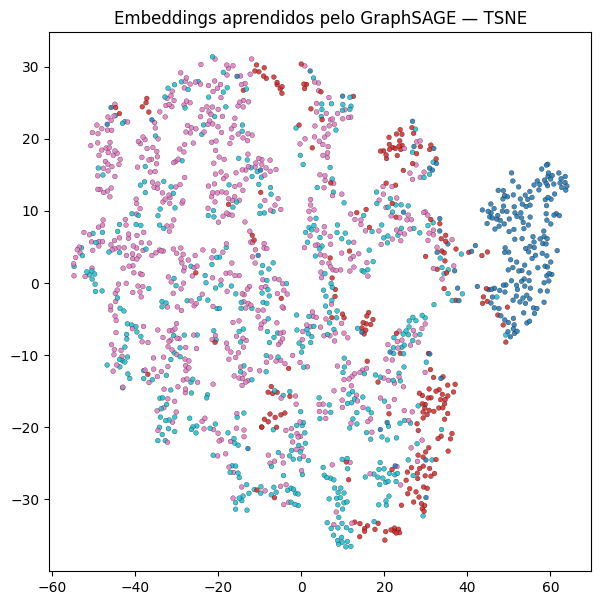

In [ ]:
import networkx as nx
from sklearn.manifold import TSNE

# (a) Grafo gene–gene completo
def plot_full_graph():
    G = nx.Graph()
    G.add_edges_from(edge_index.numpy().T)
    pos = nx.spring_layout(G, seed=42)  # reprodutível

    plt.figure(figsize=(7,7))
    nx.draw(G,pos,node_size=10,edge_color="gray",alpha=0.3)
    plt.title("Grafo gene–gene completo (correlação)")
    plt.show()

# (b) Subgrafo — genes com maior grau
def plot_top_graph(n=350):
    G = nx.Graph()
    G.add_edges_from(edge_index.numpy().T)
    deg = dict(G.degree())
    top_nodes = sorted(deg,key=deg.get,reverse=True)[:n]
    G_sub = G.subgraph(top_nodes)

    pos = nx.spring_layout(G_sub, seed=42)
    plt.figure(figsize=(7,7))
    nx.draw(G_sub,pos,node_size=20,edge_color="gray",alpha=0.6)
    plt.title(f"Subgrafo — {n} genes mais conectados (visual mais limpo)")
    plt.show()

# (c) Distribuição do grau dos nós
def plot_degree_hist():
    G = nx.Graph()
    G.add_edges_from(edge_index.numpy().T)
    grau = [d for _,d in G.degree()]

    plt.figure(figsize=(7,4))
    plt.hist(grau,bins=50,color="steelblue")
    plt.title("Distribuição do grau — genes mais/menos conectados")
    plt.xlabel("Número de conexões (grau)")
    plt.ylabel("Quantidade de genes")
    plt.show()

# (d) Embeddings após GraphSAGE
def plot_embeddings(model,data):
    model.eval()
    with torch.no_grad():
        out = model(data)               
        emb = out.cpu().numpy()         

    tsne = TSNE(n_components=2,perplexity=35,learning_rate=250)
    emb2d = tsne.fit_transform(emb)

    plt.figure(figsize=(7,7))
    plt.scatter(emb2d[:,0],emb2d[:,1],c=data.y,cmap="tab10",
                s=12,alpha=0.85,edgecolor="black",linewidth=0.2)
    plt.title("Embeddings aprendidos pelo GraphSAGE — TSNE")
    plt.show()


plot_full_graph()          # primeiro grafo
plot_top_graph(350)        # versão mais interpretável
plot_degree_hist()         # propriedades estruturais
plot_embeddings(sage, data) # imagem final — clusters por subtipo